# Import Libraries

In [30]:
from sklearn.datasets import fetch_20newsgroups
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans , AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import nltk
nltk.download('punkt_tab')
import sys
from time import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Selected 3 categories from the 20 newsgroups dataset
categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)


Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


In [5]:
df = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=False, remove=('headers', 'footers', 'quotes'))
texts = df['data']
labels = df['target']

-----
# EDA

In [8]:
df.target_names
# I am going to assume that
# 0 : comp.graphics,
# 1 : sci.space,
# 2 : talk.religion.misc

['comp.graphics', 'sci.space', 'talk.religion.misc']

In [9]:
# Finding frequency of each category
targets, frequency = np.unique(df.target, return_counts=True)
targets, frequency

(array([0, 1, 2]), array([973, 987, 628]))

In [12]:
targets_str = np.array(df.target_names)
print(list(zip(targets_str, frequency)))

[(np.str_('comp.graphics'), np.int64(973)), (np.str_('sci.space'), np.int64(987)), (np.str_('talk.religion.misc'), np.int64(628))]


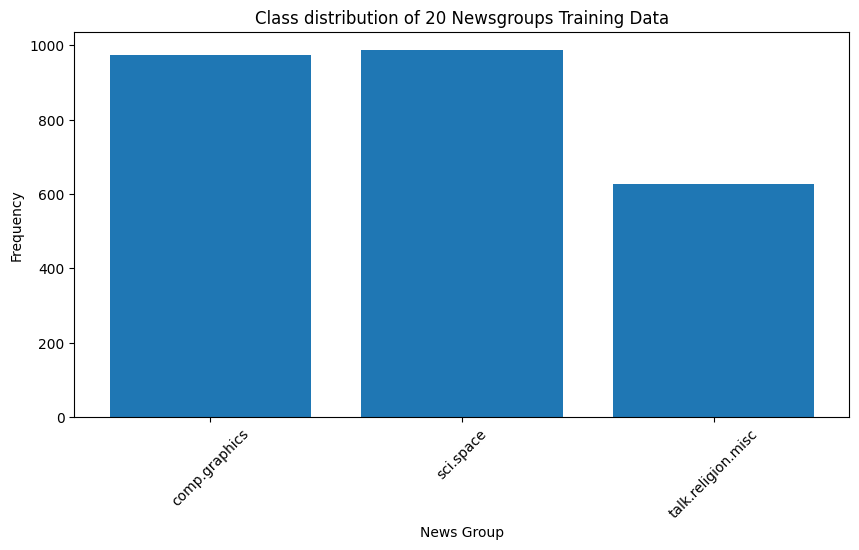

In [13]:
fig=plt.figure(figsize=(10, 5))
plt.bar(targets_str,frequency)
plt.xticks(rotation=45)
plt.title('Class distribution of 20 Newsgroups Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

`talk.religion.misc` is lower than the other 2 categories,this could introduce bias towards any those 2 categories during the analysis. might need resampling

# Text Preprocessing

In [17]:
def convert_to_np(dataset):
    return np.asarray(dataset.data), dataset.target

In [18]:
X , y = convert_to_np(df)

In [15]:
def to_lower(text):
    """
    Converting text to lower case as in, converting "Hello" to  "hello" or "Hi" to "hi".
    """
    return ' '.join([w.lower() for w in word_tokenize(text)])

In [23]:
print(X[0])
print(to_lower(X[0]))



I think I can. Largely as a result of efforts by people reading this group
writing letters and making phone calls the following has happened:

1. NASA reprogrammed funds to keep NASP alive in 1991.
2. Efforts to kill DC-X and the SSRT progam where twice twarted
   (Feb. and June of last year).
3. Gouldin kept his job in spite of heavy lobbying against him.

This may not be what Mark was thinking of but it shows that the
readers of sci.space DO have power and influence.

  Allen

i think i can . largely as a result of efforts by people reading this group writing letters and making phone calls the following has happened : 1 . nasa reprogrammed funds to keep nasp alive in 1991 . 2 . efforts to kill dc-x and the ssrt progam where twice twarted ( feb. and june of last year ) . 3 . gouldin kept his job in spite of heavy lobbying against him . this may not be what mark was thinking of but it shows that the readers of sci.space do have power and influence . allen


In [24]:
def clean_text(lower_case):
    # split text phrases into words
    words  = word_tokenize(lower_case)


    # Create a list of all the punctuations
    punctuations = [ '/', '!', '?', ';', ':', '(',')', '[',']', '-', '_', '%','@']

    # Remove all the special characters
    punctuations = re.sub(r'\W', ' ', str(lower_case))

    # Initialize the stopwords variable, which is a list of words ('and', 'the', 'i', 'yourself', 'is') that do not hold much values as key words
    stop_words  = stopwords.words('english')

    # Getting rid of all the words that contain numbers in them
    w_num = re.sub('\w*\d\w*', '', lower_case).strip()
        # remove all single characters
    lower_case = re.sub(r'\s+[a-zA-Z]\s+', ' ', lower_case)

    # Substituting multiple spaces with single space
    lower_case = re.sub(r'\s+', ' ', lower_case, flags=re.I)

    # Removing prefixed 'b'
    lower_case = re.sub(r'^b\s+', '', lower_case)

    # Removing non-english characters
    lower_case = re.sub(r'^b\s+', '', lower_case)

    # Return keywords which are not in stop words
    keywords = [word for word in words if not word in stop_words  and word in punctuations and  word in w_num]

    return keywords

In [25]:
print(to_lower(X[0]))
print(clean_text(to_lower(X[0])))

i think i can . largely as a result of efforts by people reading this group writing letters and making phone calls the following has happened : 1 . nasa reprogrammed funds to keep nasp alive in 1991 . 2 . efforts to kill dc-x and the ssrt progam where twice twarted ( feb. and june of last year ) . 3 . gouldin kept his job in spite of heavy lobbying against him . this may not be what mark was thinking of but it shows that the readers of sci.space do have power and influence . allen
['think', 'largely', 'result', 'efforts', 'people', 'reading', 'group', 'writing', 'letters', 'making', 'phone', 'calls', 'following', 'happened', 'nasa', 'reprogrammed', 'funds', 'keep', 'nasp', 'alive', 'efforts', 'kill', 'ssrt', 'progam', 'twice', 'twarted', 'june', 'last', 'year', 'gouldin', 'kept', 'job', 'spite', 'heavy', 'lobbying', 'may', 'mark', 'thinking', 'shows', 'readers', 'power', 'influence', 'allen']


In [26]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2 , max_features=3)
X = vectorizer.fit_transform(X)

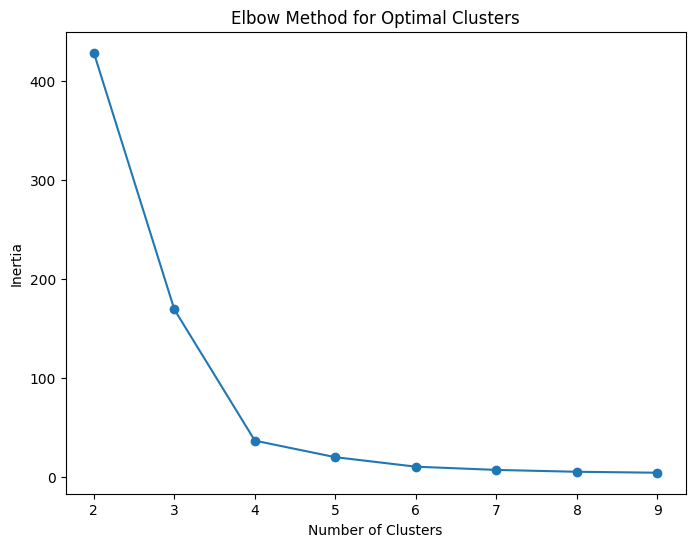

In [27]:
inertia = []
cluster_range = range(2, 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

- From the Elbow Method graph appear the "elbow" point appears around 3
clusters.

## Clustering Algorithms

In [28]:
# K-Means
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100)
kmeans_labels = kmeans.fit_predict(X)

In [31]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(X.toarray())

In [32]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X.toarray())

## Evaluation

In [33]:
silhouette_kmeans = silhouette_score(X, kmeans_labels)
silhouette_hierarchical = silhouette_score(X, hierarchical_labels)
silhouette_gmm = silhouette_score(X, gmm_labels)
print(f"Silhouette Score for K-Means: {silhouette_kmeans}")
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_hierarchical}")
print(f"Silhouette Score for GMM: {silhouette_gmm}")

Silhouette Score for K-Means: 0.8596757516973642
Silhouette Score for Hierarchical Clustering: 0.8447970786788799
Silhouette Score for GMM: 0.8511370353230382


In [34]:
# Purity Score
def purity_score(y_true, y_pred):
    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity_kmeans = purity_score(labels, kmeans_labels)
purity_hierarchical = purity_score(labels, hierarchical_labels)
purity_gmm = purity_score(labels, gmm_labels)

print(f"Purity Score for K-Means: {purity_kmeans}")
print(f"Purity Score for Hierarchical Clustering: {purity_hierarchical}")
print(f"Purity Score for GMM: {purity_gmm}")

Purity Score for K-Means: 0.48724884080370945
Purity Score for Hierarchical Clustering: 0.47913446676970634
Purity Score for GMM: 0.4891808346213292


## Visualizations

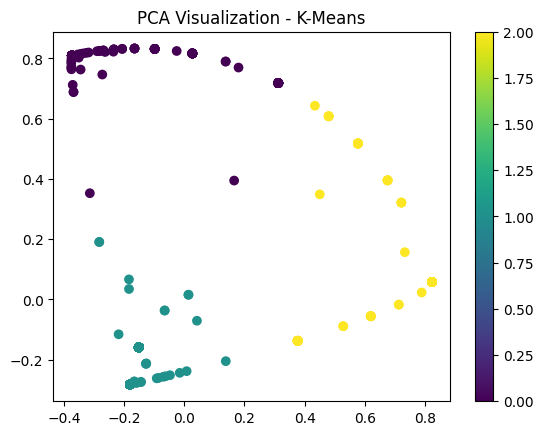

In [40]:
# PCA Visualization for K-Means
pca = PCA(n_components=2)
pca_features_kmeans = pca.fit_transform(X.toarray())
plt.scatter(pca_features_kmeans[:, 0], pca_features_kmeans[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("PCA Visualization - K-Means")
plt.colorbar()
plt.show()

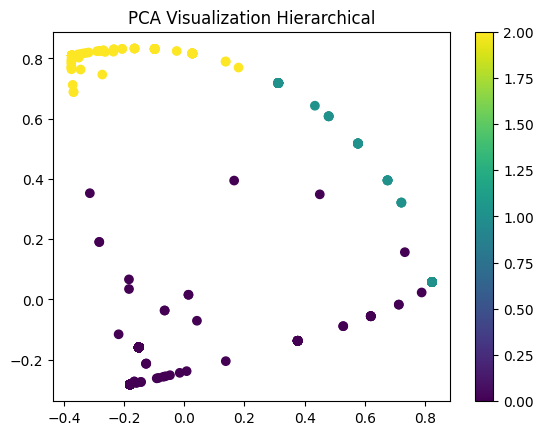

In [41]:
# PCA Visualization for Hierarchical
pca = PCA(n_components=2)
pca_features_kmeans = pca.fit_transform(X.toarray())
plt.scatter(pca_features_kmeans[:, 0], pca_features_kmeans[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title("PCA Visualization Hierarchical")
plt.colorbar()
plt.show()

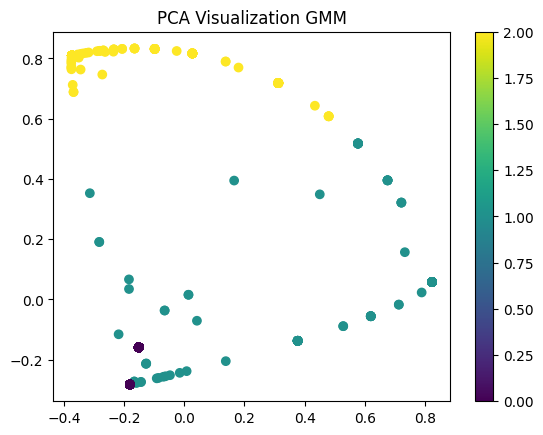

In [43]:
# PCA Visualization for GMM
pca = PCA(n_components=2)
pca_features_kmeans = pca.fit_transform(X.toarray())
plt.scatter(pca_features_kmeans[:, 0], pca_features_kmeans[:, 1], c=gmm_labels, cmap='viridis')
plt.title("PCA Visualization GMM")
plt.colorbar()
plt.show()


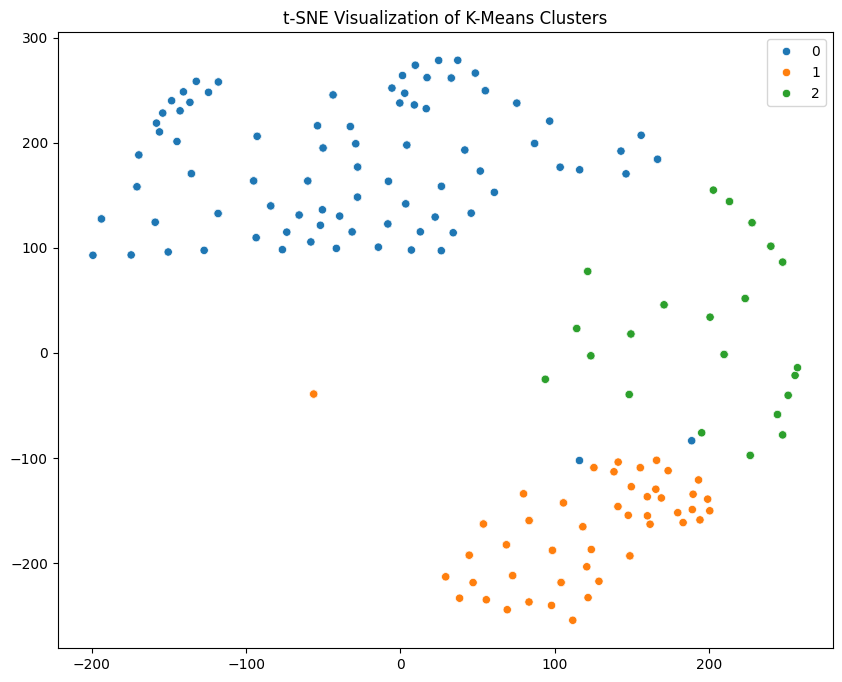

In [36]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels, palette="tab10")
plt.title("t-SNE Visualization of K-Means Clusters")
plt.show()